## Глубокое обучение в компьютерном зрении.

### Урок № 2. Сверточные нейронные сети (СНС).

**Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10
Библиотеки: [Python, Tensorflow].**

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf

import numpy as np

import random

import matplotlib.pyplot as plt
%matplotlib inline

### Произведем загрузку данных.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [4]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
x_train = x_train.reshape(-1, 32, 32, 3).astype('float32') / 255.
x_test = x_test.reshape(-1, 32, 32, 3).astype('float32') / 255.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [6]:
print('x_train type:', x_train.dtype)
print('x_test type:', x_test.dtype)

x_train type: float32
x_test type: float32


In [7]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 1)
y_test shape: (10000, 1)


In [8]:
print('y_train type:', y_train.dtype)
print('y_test type:', y_test.dtype)

y_train type: int32
y_test type: int32


In [9]:
y_train = y_train.flatten()
y_test = y_test.flatten()

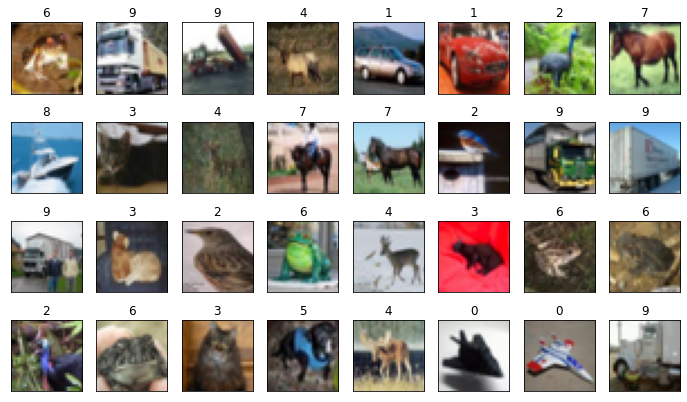

In [10]:
some_samples = x_train[:32, ...]

fig = plt.figure(figsize=(12, 7))

for i in range(some_samples.shape[0]):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(some_samples[i, :, :, :], cmap='gray')
  plt.title(y_train[i])
  plt.xticks([]), plt.yticks([])
  
plt.show()

### Подготовим пайплайн.

In [11]:
NUM_EPOCHS = 15
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

### Создадим модель CNN.

In [12]:
class Model(tf.keras.Model):

  def __init__ (self):
    super(Model, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')
    self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
    # self.conv4 = tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu')
    self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
    self.fs1 = tf.keras.layers.Dense(256, activation='relu')
    self.fs2 = tf.keras.layers.Dense(10, activation=None)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):

    out = self.conv1(inp)
    out = self.maxpool(out)
    out = self.conv2(out)
    out = self.maxpool(out)
    out = self.conv3(out)
    out = self.maxpool(out)
    # out = self.conv4(out)
    out = self.flatten(out)
    out = self.fs1(out)
    out = self.fs2(out)

    return out

model = Model()

In [13]:
# Функция расчета потерь

def loss(logits, labels):
  return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))

In [14]:
# Функция расчета точности

def accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
  return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [15]:
LEARNING_RATE = 0.001

optimazer = tf.keras.optimizers.Adam(LEARNING_RATE)
# optimazer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/adam')
# writer = tf.summary.create_file_writer('logs/rmsprop')

### Проведем обучение.

In [16]:
%%time

for iteration, (images, labels) in enumerate(train_ds):

  with tf.GradientTape() as tape:
    logits = model(images)
    loss_value = loss(logits, labels)


  grads = tape.gradient(loss_value, model.trainable_variables)
  optimazer.apply_gradients(zip(grads, model.trainable_variables))


  if iteration % 200 == 0:
    test_logits = model(x_test[:256, ...])
    accuracy_value = accuracy(test_logits, y_test[:256, ...])

    print(f'{iteration}  Accuracy: {accuracy_value.numpy()*100:.2f}')

    with writer.as_default():
      tf.summary.scalar('accuracy', accuracy_value, iteration)
      tf.summary.scalar('loss', loss_value, iteration)

0  Accuracy: 10.16
200  Accuracy: 44.92
400  Accuracy: 55.08
600  Accuracy: 58.59
800  Accuracy: 60.55
1000  Accuracy: 62.11
1200  Accuracy: 62.11
1400  Accuracy: 67.58
1600  Accuracy: 63.28
1800  Accuracy: 69.92
2000  Accuracy: 67.58
2200  Accuracy: 71.48
2400  Accuracy: 71.88
2600  Accuracy: 69.14
2800  Accuracy: 73.44
3000  Accuracy: 67.97
3200  Accuracy: 71.88
3400  Accuracy: 73.05
3600  Accuracy: 73.83
3800  Accuracy: 74.22
4000  Accuracy: 73.83
4200  Accuracy: 73.44
4400  Accuracy: 72.27
4600  Accuracy: 74.22
4800  Accuracy: 77.34
5000  Accuracy: 74.22
5200  Accuracy: 78.12
5400  Accuracy: 75.78
5600  Accuracy: 72.66
5800  Accuracy: 76.17
6000  Accuracy: 76.17
6200  Accuracy: 74.22
6400  Accuracy: 75.39
6600  Accuracy: 74.61
6800  Accuracy: 71.48
7000  Accuracy: 71.88
7200  Accuracy: 71.48
7400  Accuracy: 72.66
7600  Accuracy: 75.00
7800  Accuracy: 75.39
8000  Accuracy: 73.05
8200  Accuracy: 73.83
8400  Accuracy: 75.00
8600  Accuracy: 79.30
8800  Accuracy: 76.95
9000  Accuracy: 7

In [17]:
%%time

test_logits = model(x_test)
accuracy_value = accuracy(test_logits, y_test).numpy()
print(f'Final accuracy:  {accuracy_value*100:.2f}')

Final accuracy:  71.65
CPU times: user 1.95 s, sys: 142 ms, total: 2.1 s
Wall time: 2.09 s


In [18]:
def test_item(sample):

  logits = model(sample[None, ...])[0] 
  prediction = tf.nn.softmax(logits)
  ans = np.argmax(prediction)

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(sample[:, :, 0], cmap='gray')
  plt.xticks([]), plt.yticks([])

  ax = fig.add_subplot(1, 2, 2)
  bar_list = ax.bar(np.arange(10), prediction, align='center')
  bar_list[ans].set_color('g')
  ax.set_xticks(np.arange(10))
  ax.set_xlim([-1, 10])
  ax.grid(True)
  plt.show()
  
  print(f'predicted: {ans}')

In [19]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'
             }

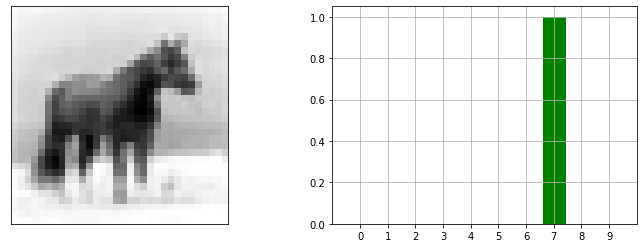

predicted: 7
True Answer: 7 -  horse


In [23]:
idx = random.randint(0, x_test.shape[0])
sample = x_test[idx, ...]
test_item(sample)

print(f'True Answer: {y_test[idx]} -  {class_dict[y_test[idx]]}')